In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import torch
import torch.nn as nn
import torchvision
from PIL import Image
import json
import os
from tqdm.notebook import tqdm

In [2]:
!nvidia-smi

Sat Nov 27 19:08:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install gdown

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.2.0-py3-none-any.whl size=14262 sha256=934b01897786618f3cf1523c9265997fd05d4449691deef6b1b62a295c24228a
  Stored in directory: /root/.cache/pip/wheels/8c/17/ff/58721d1fabdb87c21a0529948cf39e2be9af90ddbe4ad65944
Successfully built gdown


In [9]:
!gdown "https://drive.google.com/uc?id=1-0TjTRNHiuz5e2FlDqF4Uw6T4JVsXxMq"

Downloading...
From: https://drive.google.com/uc?id=1-0TjTRNHiuz5e2FlDqF4Uw6T4JVsXxMq
To: /kaggle/working/Medical+mask.zip
100%|███████████████████████████████████████| 2.68G/2.68G [00:10<00:00, 252MB/s]


In [11]:
!unzip -q "./Medical+mask.zip"

In [12]:
# picture: torch.Tensor or np.array
# boxes: indexed object
# labels: indexed object
def draw_pic_with_rect(picture, boxes, labels, n=5):
    boxes = boxes[:n]
    labels = labels[:n]
    if isinstance(picture, torch.Tensor):
        picture = (picture.detach().squeeze(0) * 256).permute(1, 2, 0).numpy()
    picture = picture.astype(dtype=np.int)

    fig, ax = plt.subplots(figsize = (15, 15))
    ax.imshow(picture)

    for box, lab in zip(boxes, labels):
        rect = matplotlib.patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                       linewidth=1, edgecolor='r', facecolor='none')
        ax.text(box[0], box[1], labels, fontsize = 12)
        ax.add_patch(rect)

    fig.show()

In [13]:
!nvidia-smi

Sat Nov 27 19:16:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

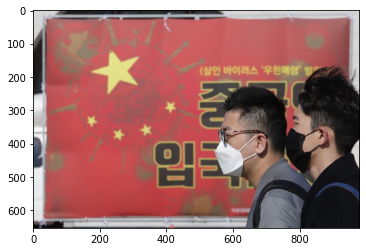

In [14]:
img = Image.open("./Medical mask/Medical Mask/images/0010.jpg")
img = np.asarray(img)
plt.imshow(img)

In [ ]:
draw_pic_with_rect(img, [[541, 394, 691, 504], [759, 353, 879, 490]], "mask")

In [ ]:
with open("/content/Medical mask/Medical Mask/annotations/0001.jpg.json") as f:
    fff = json.loads(f.read())
fff

In [15]:
labels_transform = {
    "face_with_mask": 2,
    "mask_colorful": 1,
    "mask_surgical": 1,
    "face_no_mask": 2,
    "face_with_mask_incorrect": 2,
    "face_other_covering": 2,
}

In [16]:
targets = []

cnt = 0
path_annotations = "./Medical mask/Medical Mask/annotations"
files = os.listdir(path_annotations)
files.sort()

for file in tqdm(files):
    cnt += 1
    real_path = os.path.join(path_annotations, file)
    dick = None
    with open(real_path, "r") as f:
        dick = json.loads(f.read())
    element = {
        "boxes": [],
        "labels": [],
        "filename": dick["FileName"],
    }

    for annotation in dick["Annotations"]:
        if annotation["classname"] in list(labels_transform.keys()):
            element["boxes"].append(annotation["BoundingBox"])
            element["labels"].append(labels_transform[annotation["classname"]])
            
    element["boxes"] = torch.tensor(element["boxes"])
    element["labels"] = torch.tensor(element["labels"])
    
    if len(element["labels"]) > 0:
        targets.append(element)

  0%|          | 0/6024 [00:00<?, ?it/s]

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [18]:
from torch.utils.data import DataLoader

targets_loader = DataLoader(targets, batch_size=4, shuffle=True, drop_last=True, collate_fn=lambda x: x)

In [19]:
torch.manual_seed(42)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

model.to(device)
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.Adam(params, lr=1e-4)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

  0%|          | 0/1505 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:165: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  img = torch.as_tensor(np.asarray(pic))


1493


  0%|          | 0/1505 [00:00<?, ?it/s]

KeyboardInterrupt: 

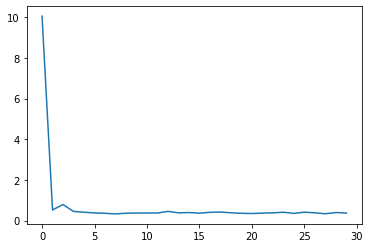

In [20]:
# The training loop trains the model for the total number of epochs.
# (1 epoch = one complete pass over the entire dataset)
num_epochs = 5
path_images = "./Medical mask/Medical Mask/images"
transform = torchvision.transforms.Compose([
    torchvision.transforms.PILToTensor(),                                           
])
model.train()
epoch_loss = []
for epoch in range(num_epochs):
    pbar = tqdm(targets_loader)
    _train_loss = []
    success_iter = 0
    for num, batch in enumerate(pbar):
        images = []

        for el in batch:
            picture_pil = Image.open(os.path.join(path_images, el["filename"]))
            images.append(transform(picture_pil).to(device, dtype=torch.float32))
        
        t = [{"boxes": el["boxes"].to(device, dtype=torch.int64), 
              "labels": el["labels"].to(device, dtype=torch.int64),
              } for el in batch]
        try:
            loss_dict = model(images, t)
        except ValueError:
            continue
        success_iter += 1

        losses = sum(loss for loss in loss_dict.values())

        _train_loss.append(losses.item())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        del images
        del t
        torch.cuda.empty_cache()
        if num % 50 == 0:
            epoch_loss.append(np.mean(_train_loss))
            pbar.set_description(f"loss_value: {np.mean(_train_loss)}")
            _train_loss = []
    
    print(success_iter)
    torch.save(model.state_dict(), f"xyi{epoch + 2}.pt")
    plt.plot(np.arange(len(epoch_loss)), np.array(epoch_loss))

In [35]:
# picture: torch.Tensor or np.array
# boxes: indexed object
# labels: indexed object
def draw_pic_with_rect(picture, boxes, labels, n=5):
    boxes = boxes[:n]
    labels = labels[:n]
    if isinstance(picture, torch.Tensor):
        picture = picture.detach().cpu().permute(1, 2, 0).numpy()
    picture = picture.astype(dtype=np.int)

    fig, ax = plt.subplots(figsize = (15, 15))
    ax.imshow(picture)

    for box, label in zip(boxes, labels):
        if label == 2:
            continue
        rect = matplotlib.patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                       linewidth=1, edgecolor='r', facecolor='none')
        ax.text(box[0], box[1], label, fontsize = 12)
        ax.add_patch(rect)

    fig.show()

In [22]:
model.eval();

In [45]:
picture_pil = Image.open("./Medical mask/Medical Mask/images/0009.jpg")
image = transform(picture_pil).to(device, dtype=torch.float32)
preds = model(image.unsqueeze(0))
preds

[{'boxes': tensor([[1.0505e+03, 1.9607e+02, 1.1779e+03, 4.0593e+02],
          [1.0616e+03, 3.3111e+02, 1.1652e+03, 3.8482e+02],
          [5.4768e+02, 3.1627e+02, 7.3428e+02, 6.2718e+02],
          [6.0836e+02, 5.0746e+02, 7.2635e+02, 6.2165e+02],
          [1.0625e+03, 2.9517e+02, 1.1716e+03, 4.0589e+02],
          [1.5835e+03, 6.9681e-01, 1.8829e+03, 6.3834e+02],
          [4.7801e+02, 2.1726e+02, 7.2780e+02, 6.9391e+02],
          [4.9875e+02, 3.7716e+02, 7.2583e+02, 5.4922e+02],
          [5.4279e+02, 4.5905e+02, 7.2517e+02, 6.5670e+02],
          [1.1158e+01, 1.3765e+02, 3.2095e+02, 7.4864e+02],
          [1.1375e+01, 1.0930e+02, 3.2124e+02, 7.3130e+02],
          [1.5773e+03, 1.2520e+02, 1.9033e+03, 6.9285e+02],
          [1.7524e+02, 6.2453e+02, 4.9311e+02, 1.2307e+03],
          [7.3755e+02, 2.5031e+01, 1.5869e+03, 6.8081e+02],
          [5.8373e+02, 4.7804e+02, 6.8570e+02, 6.1334e+02],
          [1.6285e+03, 3.8570e+02, 1.8544e+03, 6.3664e+02],
          [1.6482e+03, 4.9959e+

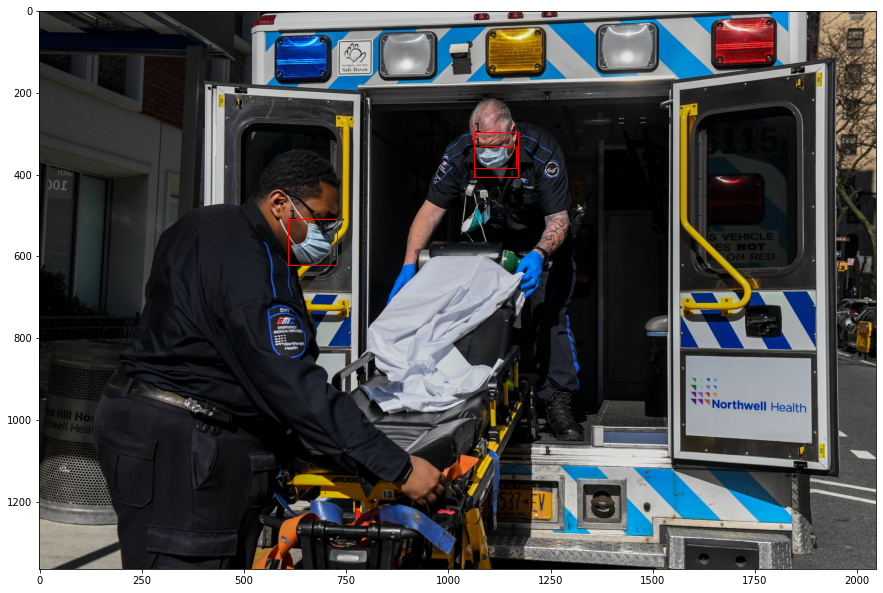

In [48]:
draw_pic_with_rect(image.cpu().detach().to(dtype=torch.int), preds[0]["boxes"].cpu().detach(), preds[0]["labels"].cpu().detach().tolist(), 5)

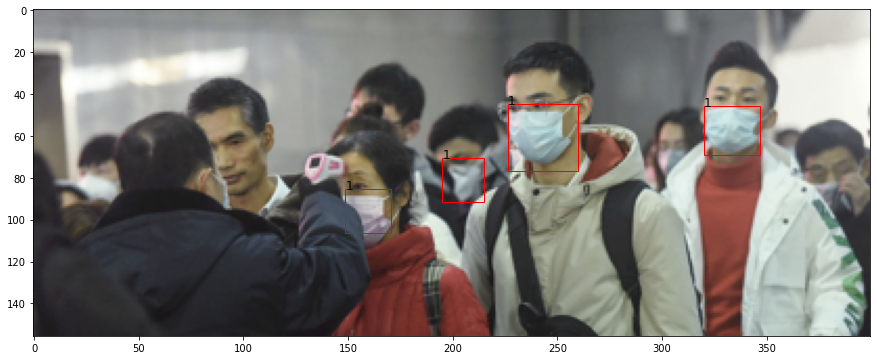

In [65]:
picture_pil = Image.open("../input/face-mask-detection/images/maksssksksss1.png")
image = transform(picture_pil).to(device, dtype=torch.float32)[:3, :, :]
preds = model(image.unsqueeze(0))
draw_pic_with_rect(image.cpu().detach().to(dtype=torch.int), preds[0]["boxes"].cpu().detach(), preds[0]["labels"].cpu().detach().tolist(), 15)

In [66]:
!gdown --folder --id "1kLAh4-si-_8TU7b_P-rTtzlqTyB2CjqD"

Retrieving folder list
Processing file 1C4G-NpnDO5SpSm4te9lElGfXz99Wo1j4 dlib_face_recognition_resnet_model_v1.dat.bz2
Processing file 1krSowy72U2hoZYQWfQJkqXVv8T04s3jd img1.png
Processing file 12893mP6Cf0YeAN2bCHhTWrTVvfMun7mW img2.png
Processing file 1iSsEFwZeu7pjYTwGkfIIMiTbhXKAduNN sev2.jpg
Processing file 1Wk005zworwonkBOC0LHHsVmmP89T1UVG seva1.jpg
Processing file 1yB7sKkSfJxZRH5dGFLjJ63tRKy8_-Ims shape_predictor_68_face_landmarks.dat
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1C4G-NpnDO5SpSm4te9lElGfXz99Wo1j4
To: /kaggle/working/Tulahack/dlib_face_recognition_resnet_model_v1.dat.bz2
100%|███████████████████████████████████████| 21.4M/21.4M [00:00<00:00, 297MB/s]
Downloading...
From: https://drive.google.com/uc?id=1krSowy72U2hoZYQWfQJkqXVv8T04s3jd
To: /kaggle/working/Tulahack/img1.png
100%|████████████████████████████████████████| 184k/184k [00:00<00:00, 94.9MB/s]
Download

In [68]:
!ls Tulahack

dlib_face_recognition_resnet_model_v1.dat.bz2
img1.png
img2.png
sev2.jpg
seva1.jpg
shape_predictor_68_face_landmarks.dat


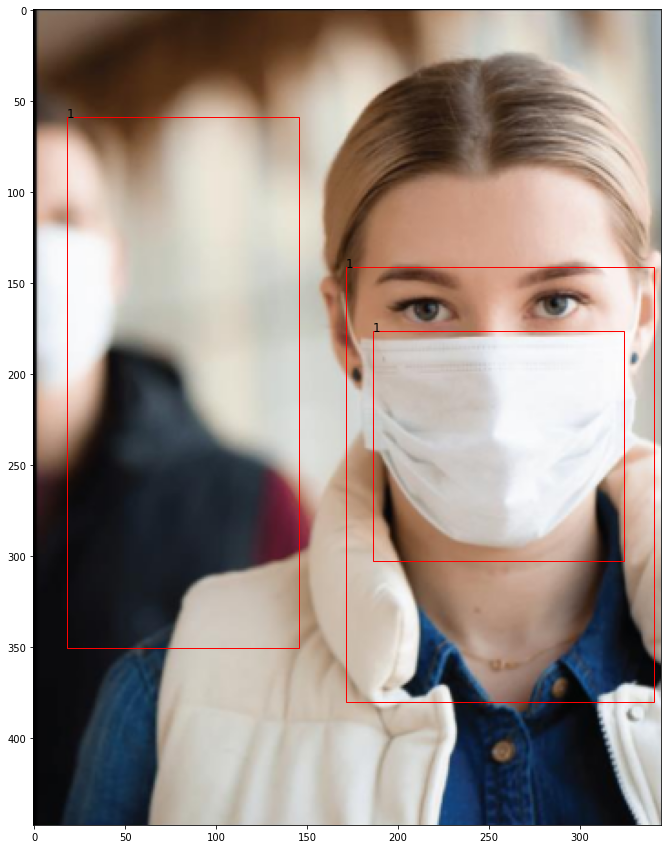

In [70]:
picture_pil = Image.open("Tulahack/img1.png")
image = transform(picture_pil).to(device, dtype=torch.float32)[:3, :, :]
preds = model(image.unsqueeze(0))
draw_pic_with_rect(image.cpu().detach().to(dtype=torch.int), preds[0]["boxes"].cpu().detach(), preds[0]["labels"].cpu().detach().tolist(), 20)

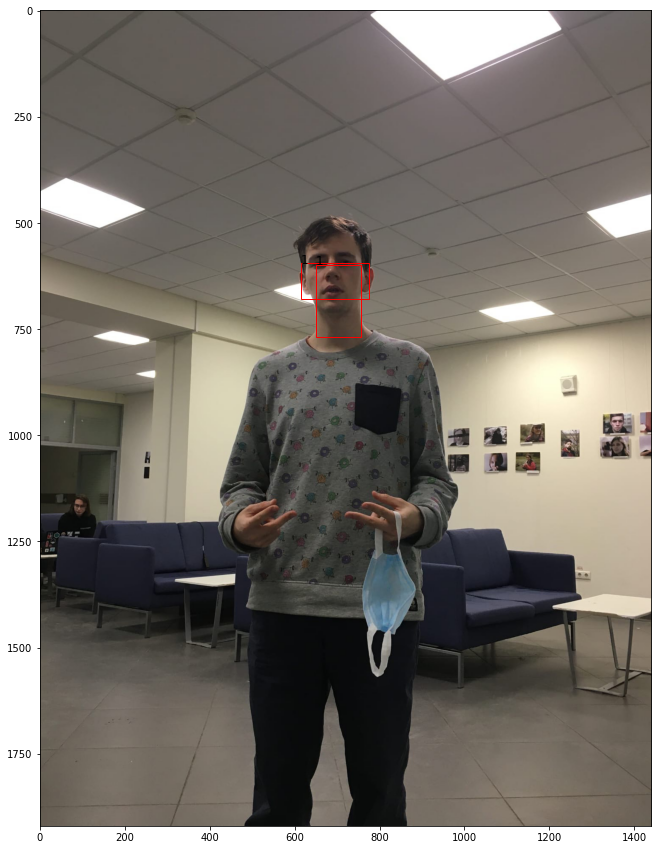

In [75]:
picture_pil = Image.open("Tulahack/seva1.jpg")
image = transform(picture_pil).to(device, dtype=torch.float32)[:3, :, :]
preds = model(image.unsqueeze(0))
draw_pic_with_rect(image.cpu().detach().to(dtype=torch.int), preds[0]["boxes"].cpu().detach(), preds[0]["labels"].cpu().detach().tolist(),5)

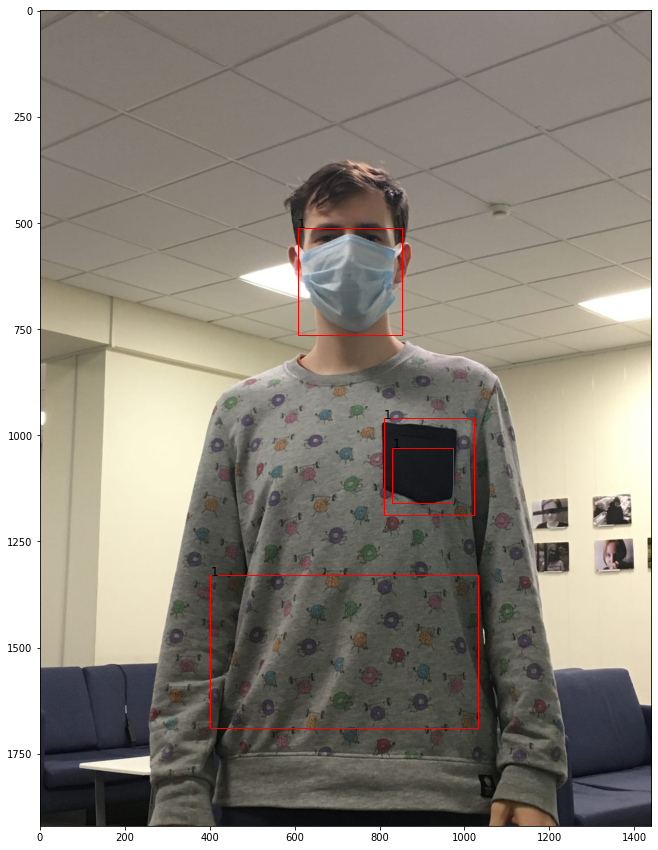

In [76]:
picture_pil = Image.open("Tulahack/sev2.jpg")
image = transform(picture_pil).to(device, dtype=torch.float32)[:3, :, :]
preds = model(image.unsqueeze(0))
draw_pic_with_rect(image.cpu().detach().to(dtype=torch.int), preds[0]["boxes"].cpu().detach(), preds[0]["labels"].cpu().detach().tolist(), 20)pg")
image = transform(picture_pil).to(device, dtype=torch.float32)[:3, :, :]
preds = model(image.unsqueeze(0))